# Clustering Cell Sample menggunakan SVM (Manual)

Oleh Denny Dewanta

## Pre-processing

In [24]:
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [25]:
#Baca dataset
df = pd.read_csv("cell_samples.csv")
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [27]:
# Mengatasi datatype yang masih object
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')

In [28]:
# Buat dataframe untuk feature
df_feature = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
df_feature = np.asarray(df_feature)
df_feature

array([[ 5,  1,  1, ...,  3,  1,  1],
       [ 5,  4,  4, ...,  3,  2,  1],
       [ 3,  1,  1, ...,  3,  1,  1],
       ...,
       [ 5, 10, 10, ...,  8, 10,  2],
       [ 4,  8,  6, ..., 10,  6,  1],
       [ 4,  8,  8, ..., 10,  4,  1]], dtype=int64)

In [29]:
# Buat dataframe untuk label
df['Class'] = df['Class'].astype('int')
df_label = np.asarray(df['Class'])
df_label[0:20]

array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2])

In [30]:
# Mengubah label menjadi 1 atau -1
df_label = df_label.astype(int)
for z in range(len(df_label)):
  if(df_label[z] == 4):
    df_label[z] = 1
  if(df_label[z] == 2):
    df_label[z] = -1

df_label[0:20]

array([-1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1,  1, -1])

## Support Vector Machine

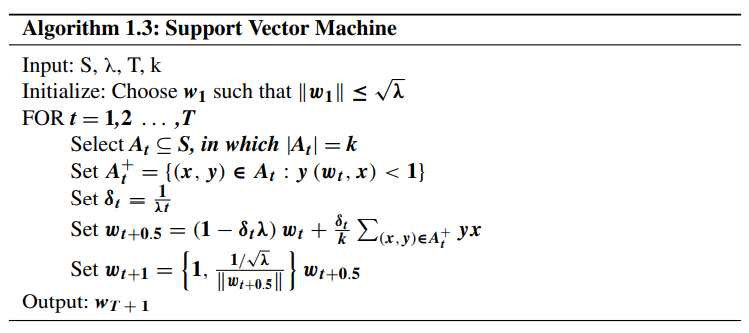

In [31]:
class SVM():
  def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
    self.kernels = {
        'linear' : self.kernel_linear,
        'quadratic' : self.kernel_quadratic
    }
    self.max_iter = max_iter
    self.kernel_type = kernel_type
    self.C = C
    self.epsilon = epsilon
  def fit(self, X, y):
    # n = number of samples
    n = X.shape[0]
    # buat zeros
    alpha = np.zeros((n))
    # memilih kernel
    kernel = self.kernels[self.kernel_type]
    
    iteration = 0
    while True:
      iteration += 1
      # menyimpan alpha
      alpha_prev = np.copy(alpha)
            
      for j in range(0, n):  
        # mengambil random sample dimana i not equal to j
        i = self.get_rnd_int(0, n-1, j)
        x_i = X[i,:]
        x_j = X[j,:]
        y_i = y[i]
        y_j = y[j]
        k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
           
        if k_ij == 0:
          continue
                
        # Menghitung L dan H
        alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
        (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

        # Menghitung model parameter
        self.w = self.calc_w(alpha, y, X)
        self.b = self.calc_b(X, y, self.w)

        # Menghitung E_i, E_j
        E_i = self.E(x_i, y_i, self.w, self.b)
        E_j = self.E(x_j, y_j, self.w, self.b)

        # Alpha values
        alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
        alpha[j] = max(alpha[j], L)
        alpha[j] = min(alpha[j], H)
        alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

      # Terminating condition: reacing convergence
      diff = np.linalg.norm(alpha - alpha_prev)
      if diff < self.epsilon:
        break

      #Terminating condition: Reaching max iterations
      if iteration >= self.max_iter:
        print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
        return
            
    # Menghitung final model parameters
    self.b = self.calc_b(X, y, self.w)
    if self.kernel_type == 'linear':
      self.w = self.calc_w(alpha, y, X)
            
            
  def predict(self, X):
    return self.h(X, self.w, self.b)
    
  def calc_b(self, X, y, w):
    b_tmp = y - np.dot(w.T, X.T)
    return np.mean(b_tmp)
    
  def calc_w(self, alpha, y, X):
    return np.dot(alpha * y, X)
    
  # Predict
  def h(self, X, w, b):
    return np.sign(np.dot(w.T, X.T) + b).astype(int)
    
  # Error
  def E(self, x_k, y_k, w, b):
    return self.h(x_k, w, b) - y_k
    
  def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
    if(y_i != y_j):
      return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
    else:
      return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
        
  def get_rnd_int(self, a,b,z):
    i = z
    cnt=0
    while i == z and cnt<1000:
      i = rnd.randint(a,b)
      cnt=cnt+1
    return i
    
  # Define kernels
  def kernel_linear(self, x1, x2):
    return np.dot(x1, x2.T)
  def kernel_quadratic(self, x1, x2):
    return (np.dot(x1, x2.T) ** 2)
    
  # Print parameters SVM
  def print_info(self):
    print("Support Vector Machine Algorithm Parameters")
    print("C:",self.C)
    print("max_iter:",self.max_iter)
    print("epsilon:",self.epsilon)
    print("kernel_type:",self.kernel_type)

## Accuracy

In [32]:
def calc_acc(y, y_hat):
  correct_counter = 0
  for i in range(0,len(y)):
    if(y[i] == -1 and y_hat[i] == -1):
      correct_counter = correct_counter + 1
    if(y[i] == 1 and y_hat[i] == 1):
      correct_counter = correct_counter + 1
  return (correct_counter/len(y))

## Main

Support Vector Machine Algorithm Parameters
C: 1
max_iter: 1000
epsilon: 0.001
kernel_type: linear

Accuracy: 0.9781021897810219


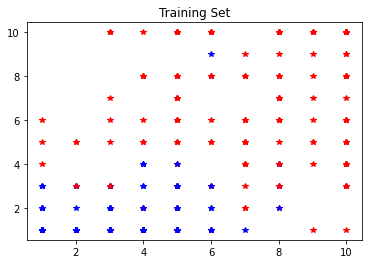

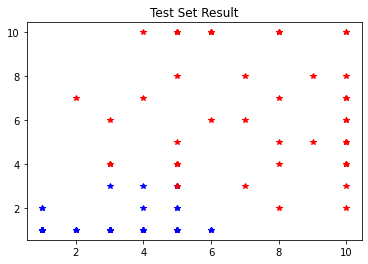

In [33]:
# Parameter svm
C = 1
max_iter = 1000
epsilon = 0.001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)
    
# Split dataframe menjadi 0.8 training dan 0.2 test
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label, test_size = 0.2, random_state = 0)
global support_vectors
model.fit(X_train,y_train)

# Make prediction
y_hat = model.predict(X_test)

# Calculate accuracy
accuracy = calc_acc(y_test, y_hat)
model.print_info()
print("\nAccuracy:",accuracy)
for i in range(0,len(y_train)):
    if(y_train[i] == 1):
        plt.plot(X_train[i,0],X_train[i,1],'r*')
    else:
        plt.plot(X_train[i,0],X_train[i,1],'b*')
plt.title("Training Set")
plt.show()
    
# Plot hasil
for i in range(0,len(y_hat)):
    if(y_hat[i] == 1):
        plt.plot(X_test[i,0],X_test[i,1],'r*')
    else:
        plt.plot(X_test[i,0],X_test[i,1],'b*')
plt.title("Test Set Result")
plt.show()